In [1]:
# Dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mpl_toolkits
%matplotlib inline
import re
import tensorflow as tf
from keras.callbacks import ModelCheckpoint

In [2]:
# Read data
data = pd.read_csv("zillow_wake_co.csv")

In [3]:
data.head()

,props.dateSold,props.propertyType,props.lotAreaValue,props.address,props.variableData.text,props.variableData.type,props.zestimate,props.imgSrc,props.price,props.bedrooms,...,props.daysOnZillow,props.bathrooms,props.livingArea,props.country,props.currency,props.lotAreaUnit,props.hasImage,Unnamed: 23,Unnamed: 24,Unnamed: 25
0,1682665200000,SINGLE_FAMILY,0.920000,"7525 Matherly Dr, Wake Forest, NC 27587",Sold 04/28/2023,RECENTLY_SOLD,471400.0,https://photos.zillowstatic.com/fp/f5b8c1b3a5e...,471900,3.0,...,-1,3.0,2245.0,USA,USD,acres,True,NaN,NaN,NaN
1,1682665200000,SINGLE_FAMILY,0.350000,"132 W Holding Ave, Wake Forest, NC 27587",Sold 04/28/2023,RECENTLY_SOLD,373700.0,https://photos.zillowstatic.com/fp/cc3dddbd058...,375000,3.0,...,-1,3.0,1815.0,USA,USD,acres,True,NaN,NaN,NaN
2,1682665200000,SINGLE_FAMILY,0.429982,"2809 Stirrup Ct, Wake Forest, NC 27587",Sold 04/28/2023,RECENTLY_SOLD,446000.0,https://maps.googleapis.com/maps/api/staticmap...,382500,3.0,...,-1,3.0,2350.0,USA,USD,acres,True,NaN,NaN,NaN
3,1682665200000,SINGLE_FAMILY,0.260000,"900 Finchurch Cir, Wake Forest, NC 27587",Sold 04/28/2023,RECENTLY_SOLD,329700.0,https://photos.zillowstatic.com/fp/c16d597cdf7...,330000,3.0,...,-1,2.0,1332.0,USA,USD,acres,True,NaN,NaN,NaN
4,1682665200000,SINGLE_FAMILY,0.920000,"2812 Kimmon Way, Wake Forest, NC 27587",Sold 04/28/2023,RECENTLY_SOLD,677600.0,https://photos.zillowstatic.com/fp/bf2640f3101...,680000,4.0,...,-1,3.0,2600.0,USA,USD,acres,True,NaN,NaN,NaN


In [4]:
# Extract zip code from address
data['zip'] = data['props.address'].str.extract('(?<=NC )([^,]*)(?=$)', expand = True)
data['zip'].astype(str).astype(int)
data['zip'].head()

0    27587
1    27587
2    27587
3    27587
4    27587
Name: zip, dtype: object

In [5]:
# Extract city code from address
data['city'] = data['props.address'].str.extract('(?<=, )([^,]*)(?=,)', expand = True)   
data['city'].head()

0    Wake Forest
1    Wake Forest
2    Wake Forest
3    Wake Forest
4    Wake Forest
Name: city, dtype: object

In [6]:
# Create data_df dataframe from select columns in data dataframe
data_df = data[['city','zip','props.zestimate','props.propertyType','props.bedrooms','props.bathrooms','props.livingArea','props.lotAreaValue','props.latitude','props.longitude']]

# Drop rows where bedrooms, bathrooms, or livingArea = 0
data_df = data_df[data_df['props.bedrooms'] != 0]
data_df = data_df[data_df['props.bathrooms'] != 0]
data_df = data_df[data_df['props.livingArea'] != 0]

# Drop NA
data_df = data_df.dropna()

data_df.head()

,city,zip,props.zestimate,props.propertyType,props.bedrooms,props.bathrooms,props.livingArea,props.lotAreaValue,props.latitude,props.longitude
0,Wake Forest,27587,471400.0,SINGLE_FAMILY,3.0,3.0,2245.0,0.920000,35.997555,-78.544770
1,Wake Forest,27587,373700.0,SINGLE_FAMILY,3.0,3.0,1815.0,0.350000,35.972195,-78.516880
2,Wake Forest,27587,446000.0,SINGLE_FAMILY,3.0,3.0,2350.0,0.429982,35.937810,-78.527550
3,Wake Forest,27587,329700.0,SINGLE_FAMILY,3.0,2.0,1332.0,0.260000,35.994972,-78.504776
4,Wake Forest,27587,677600.0,SINGLE_FAMILY,4.0,3.0,2600.0,0.920000,36.019070,-78.553570


In [7]:
# Change dtypes of columns
data_df['zip'] = data_df['zip'].astype(str).astype(int)
data_df['props.bedrooms'] = data_df['props.bedrooms'].astype(int)
data_df['props.bathrooms'] = data_df['props.bathrooms'].astype(int)
data_df.dtypes

city                   object
zip                     int32
props.zestimate       float64
props.propertyType     object
props.bedrooms          int32
props.bathrooms         int32
props.livingArea      float64
props.lotAreaValue    float64
props.latitude        float64
props.longitude       float64
dtype: object

In [8]:
# Describe data_df
data_df.describe()

,zip,props.zestimate,props.bedrooms,props.bathrooms,props.livingArea,props.lotAreaValue,props.latitude,props.longitude
count,4487.000000,4.487000e+03,4487.000000,4487.000000,4487.000000,4487.000000,4487.000000,4487.000000
mean,27566.559840,5.518166e+05,3.626254,3.019835,2455.211723,3002.582726,35.785668,-78.688503
std,41.793016,3.028521e+05,0.868817,1.015620,1602.316504,3651.977465,0.113166,0.133234
min,27502.000000,3.220000e+04,1.000000,1.000000,252.000000,0.000000,35.450110,-78.997856
25%,27523.000000,3.739000e+05,3.000000,2.000000,1657.000000,0.430000,35.725284,-78.798000
50%,27571.000000,4.800000e+05,4.000000,3.000000,2270.000000,2.280000,35.778362,-78.694030
75%,27607.000000,6.367000e+05,4.000000,3.000000,2948.500000,6534.000000,35.857458,-78.574355
max,27617.000000,4.598200e+06,7.000000,10.000000,73140.000000,10846.440000,36.145874,-78.401010


In [9]:
# Determine # of unique values per column
data_df.nunique()

city                    13
zip                     23
props.zestimate       3126
props.propertyType       7
props.bedrooms           7
props.bathrooms         10
props.livingArea      2280
props.lotAreaValue     626
props.latitude        3709
props.longitude       3647
dtype: int64

<function seaborn.utils.despine(fig=None, ax=None, top=True, right=True, left=False, bottom=False, offset=None, trim=False)>

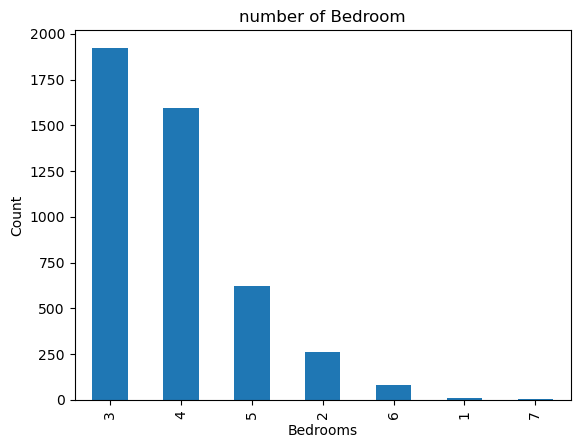

In [10]:
data_df['props.bedrooms'].value_counts().plot(kind='bar')
plt.title('number of Bedroom')
plt.xlabel('Bedrooms')
plt.ylabel('Count')
sns.despine

Text(0.5, 1.0, 'Price vs Square Feet')

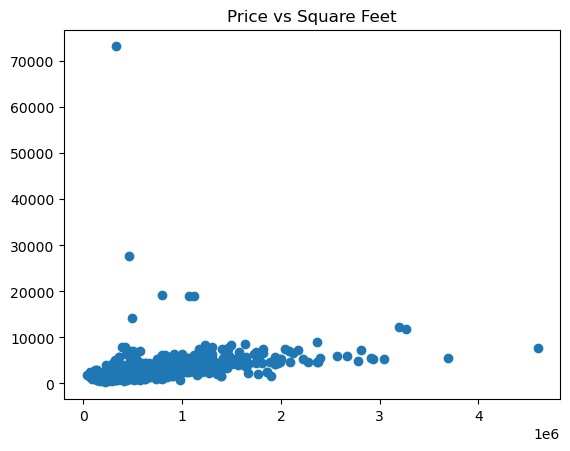

In [11]:
plt.scatter(data_df["props.zestimate"],data_df["props.livingArea"])
plt.title("Price vs Square Feet")

In [12]:
# Create dataframe that contains all variables except the zestimates
train_data = data_df.drop(['props.zestimate'], axis=1)
train_data

,city,zip,props.propertyType,props.bedrooms,props.bathrooms,props.livingArea,props.lotAreaValue,props.latitude,props.longitude
0,Wake Forest,27587,SINGLE_FAMILY,3,3,2245.0,0.920000,35.997555,-78.544770
1,Wake Forest,27587,SINGLE_FAMILY,3,3,1815.0,0.350000,35.972195,-78.516880
2,Wake Forest,27587,SINGLE_FAMILY,3,3,2350.0,0.429982,35.937810,-78.527550
3,Wake Forest,27587,SINGLE_FAMILY,3,2,1332.0,0.260000,35.994972,-78.504776
4,Wake Forest,27587,SINGLE_FAMILY,4,3,2600.0,0.920000,36.019070,-78.553570
...,...,...,...,...,...,...,...,...,...
4535,Apex,27523,SINGLE_FAMILY,2,3,5379.0,0.250000,35.773750,-78.919330
4536,Apex,27523,SINGLE_FAMILY,2,3,5207.0,9583.000000,35.770424,-78.921500
4537,Apex,27523,SINGLE_FAMILY,4,4,3225.0,5662.800000,35.770424,-78.921500
4538,Apex,27523,SINGLE_FAMILY,3,2,1565.0,1.720000,35.767048,-78.902534


In [13]:
# categorical columns
categorical_cols = ['city','props.propertyType']

train_data= pd.get_dummies(train_data, columns = categorical_cols)
train_data

,zip,props.bedrooms,props.bathrooms,props.livingArea,props.lotAreaValue,props.latitude,props.longitude,city_Apex,city_Cary,city_Creedmoor,...,city_Raleigh,city_Rolesville,city_Wake Forest,props.propertyType_APARTMENT,props.propertyType_CONDO,props.propertyType_LOT,props.propertyType_MANUFACTURED,props.propertyType_MULTI_FAMILY,props.propertyType_SINGLE_FAMILY,props.propertyType_TOWNHOUSE
0,27587,3,3,2245.0,0.920000,35.997555,-78.544770,0,0,0,...,0,0,1,0,0,0,0,0,1,0
1,27587,3,3,1815.0,0.350000,35.972195,-78.516880,0,0,0,...,0,0,1,0,0,0,0,0,1,0
2,27587,3,3,2350.0,0.429982,35.937810,-78.527550,0,0,0,...,0,0,1,0,0,0,0,0,1,0
3,27587,3,2,1332.0,0.260000,35.994972,-78.504776,0,0,0,...,0,0,1,0,0,0,0,0,1,0
4,27587,4,3,2600.0,0.920000,36.019070,-78.553570,0,0,0,...,0,0,1,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4535,27523,2,3,5379.0,0.250000,35.773750,-78.919330,1,0,0,...,0,0,0,0,0,0,0,0,1,0
4536,27523,2,3,5207.0,9583.000000,35.770424,-78.921500,1,0,0,...,0,0,0,0,0,0,0,0,1,0
4537,27523,4,4,3225.0,5662.800000,35.770424,-78.921500,1,0,0,...,0,0,0,0,0,0,0,0,1,0
4538,27523,3,2,1565.0,1.720000,35.767048,-78.902534,1,0,0,...,0,0,0,0,0,0,0,0,1,0


In [14]:
# # Encode categorical data sets of city and props.propertyType
# from sklearn.preprocessing import LabelEncoder
# from sklearn.preprocessing import OneHotEncoder

# # integer encode
# label_encoder = LabelEncoder()
# integer_encoded = label_encoder.fit_transform(train_data['city'])
# print(integer_encoded)
# # binary encode
# onehot_encoder = OneHotEncoder(sparse=False)
# integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
# onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
# print(onehot_encoded)

In [15]:
# # Replace with encoded columns
# train_data['city'] = onehot_encoded
# train_data

In [16]:
# set up linear regression on data
from sklearn.linear_model import LinearRegression
reg = LinearRegression()

In [17]:
# Train-Test-Split data
from sklearn.model_selection import train_test_split

labels = data_df['props.zestimate']
x_train, x_test, y_train, y_test = train_test_split(train_data, labels, test_size = 0.20, random_state = 42)

In [29]:
reg.fit(x_train,y_train)

LinearRegression()

In [25]:
reg.score(x_test,y_test)

0.577620483927017

In [30]:
from sklearn import ensemble
clf = ensemble.GradientBoostingRegressor(n_estimators = 400, max_depth = 5, min_samples_split = 2,
          learning_rate = 0.1, loss = 'squared_error')

In [31]:
clf.fit(x_train, y_train)

GradientBoostingRegressor(max_depth=5, n_estimators=400)

In [32]:
clf.score(x_test,y_test)

0.8197018132134365

In [18]:
# Create a StandardScaler instances
from sklearn.preprocessing import StandardScaler,OneHotEncoder
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(x_train)

# Scale the data
X_train_scaled = X_scaler.transform(x_train)
X_test_scaled = X_scaler.transform(x_test)

In [19]:
# Define model - deep neural net
number_input_features = len(X_train_scaled[0])
hidden_nodes_layer1 = 80
hidden_nodes_layer2 = 50

nn = tf.keras.models.Sequential()

# First hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer1, input_dim=number_input_features, activation="relu"))

# Second hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer2, activation="relu"))

# Output layer
nn.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

# Check the structure of the model
nn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 80)                2240      
                                                                 
 dense_1 (Dense)             (None, 50)                4050      
                                                                 
 dense_2 (Dense)             (None, 1)                 51        
                                                                 
Total params: 6,341
Trainable params: 6,341
Non-trainable params: 0
_________________________________________________________________


In [20]:
# Compile the model
nn.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [21]:
# Create a callback that saves the model's weights every 5 epochs
checkpoint = ModelCheckpoint("best_model.hdf5", monitor='loss', verbose=1,
    save_best_only=True, mode='auto', period=5)

In [22]:
# Train the model
fit_model = nn.fit(X_train_scaled,y_train,
                   epochs=100,callbacks=[checkpoint])

Epoch 1/100
113/113 [==============================] - 2s 1ms/step - loss: -8357937.0000 - accuracy: 0.0000e+00
Epoch 2/100
113/113 [==============================] - 0s 974us/step - loss: -107244504.0000 - accuracy: 0.0000e+00
Epoch 3/100
113/113 [==============================] - 0s 924us/step - loss: -497380864.0000 - accuracy: 0.0000e+00
Epoch 4/100
113/113 [==============================] - 0s 888us/step - loss: -1405804416.0000 - accuracy: 0.0000e+00
Epoch 5/100
 59/113 [==============>...............] - ETA: 0s - loss: -2530695168.0000 - accuracy: 0.0000e+00
Epoch 5: loss improved from inf to -3031710976.00000, saving model to best_model.hdf5
113/113 [==============================] - 0s 1ms/step - loss: -3031710976.0000 - accuracy: 0.0000e+00
Epoch 6/100
113/113 [==============================] - 0s 969us/step - loss: -5590582272.0000 - accuracy: 0.0000e+00
Epoch 7/100
113/113 [==============================] - 0s 885us/step - loss: -9227867136.0000 - accuracy: 0.0000e+00
Epoch

113/113 [==============================] - 0s 1ms/step - loss: -2644273004544.0000 - accuracy: 0.0000e+00
Epoch 53/100
113/113 [==============================] - 0s 880us/step - loss: -2773522055168.0000 - accuracy: 0.0000e+00
Epoch 54/100
113/113 [==============================] - 0s 879us/step - loss: -2906659487744.0000 - accuracy: 0.0000e+00
Epoch 55/100
 58/113 [==============>...............] - ETA: 0s - loss: -2979924279296.0000 - accuracy: 0.0000e+00
Epoch 55: loss improved from -2396586508288.00000 to -3043421847552.00000, saving model to best_model.hdf5
113/113 [==============================] - 0s 957us/step - loss: -3043421847552.0000 - accuracy: 0.0000e+00
Epoch 56/100
113/113 [==============================] - 0s 925us/step - loss: -3184143630336.0000 - accuracy: 0.0000e+00
Epoch 57/100
113/113 [==============================] - 0s 942us/step - loss: -3329414922240.0000 - accuracy: 0.0000e+00
Epoch 58/100
113/113 [==============================] - 0s 916us/step - loss: -3

In [23]:
# Evaluate the model using the test data
model_loss, model_accuracy = nn.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

29/29 - 0s - loss: -1.4448e+13 - accuracy: 0.0000e+00 - 163ms/epoch - 6ms/step
Loss: -14448012034048.0, Accuracy: 0.0
